# Séance 4: Détermination de la qualité d'une bonne trajectoire

Le but de la séance sera de déterminer en quoi une trajectoire sera de bonne qualité, en fonction de différents paramètres, tels que par exemple le temps et l'espace.

Il faudra aussi améliorer l'algorithme de nettoyage, car il se trouve que celui que nous avions utilisé n'était pas correct.

Nous allons nous intéresser à l'ID 11, car c'est le seul où on peut y voir un déplacement, mais aussi un nombre d'enregistrements correct.

In [1]:
import pandas as pd
import gmaps
import gmaps.datasets
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import statistics
import glob

from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as image
import matplotlib.pyplot as plt


Importons tout d'abord nos données nettoyées de la dernière fois.
On prenait la donnée GPS la plus utilisée pour chaque intervalle d'une minute

In [2]:
df = pd.read_csv("Data/Privamov/id11.txt",sep="\t", header=None,  names = ["Id", "DateTime", "Latitude", "Longitude"])
coord11 = df[["Latitude", "Longitude"]]
;

''

In [3]:
from geopy.distance import vincenty
liste = []
for i in range(1, len(df)):
    deltaT = datetime.strptime(df.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(df.DateTime.iloc[i-1], '%Y-%m-%d %H:%M:%S.%f')
    if deltaT.total_seconds() == 0:
        continue
    iterloc1 = (df.Latitude.iloc[i], df.Longitude.iloc[i])
    iterloc2 = (df.Latitude.iloc[i], df.Longitude.iloc[i-1])
    speed = (vincenty(iterloc1, iterloc2).kilometers) / (deltaT.total_seconds() / 3600)
    liste.append(speed)

Affichons maintenant la vitesse avec les données nettoyées

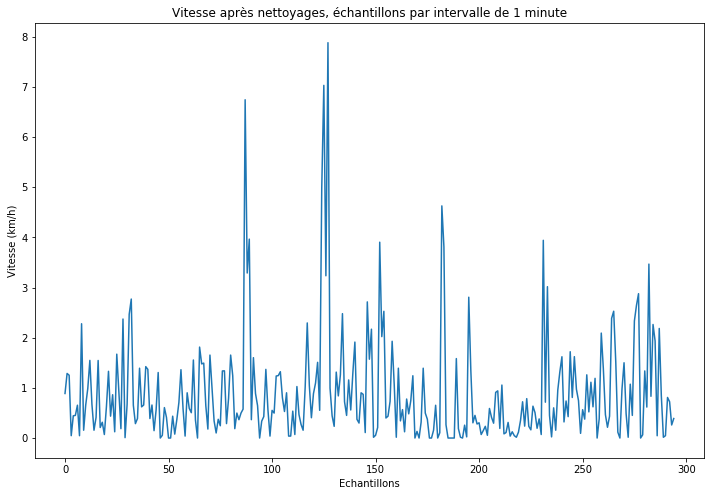

7.880845590881933

In [4]:
plt.figure(figsize=(12,8))
plt.xlabel('Echantillons')
plt.ylabel('Vitesse (km/h)')
plt.plot(liste)
plt.title("Vitesse après nettoyages, échantillons par intervalle de 1 minute")
plt.show()
max(liste)

#### Remarque
Nous avons néanmoins remarqué quelques points négatifs avec l'algorithme de nettoyage utilisé.
L'algorithme ne prend pas vraiment en compte les intervalles de temps où les données sont manquantes, ce qui peut fausser les trajectoires.
Il nous faut donc changer l'algorithme afin que celui-ci prenne en compte les intervalles où il manque des données.

## Définition du nouvel algorithme

In [71]:
def cleanMethodMinutes(frameParam, delta):
    listeLongitude = []
    listeLatitude = []
    listeTemps = []
    listeLongitude2 = []
    listeLatitude2 = []
    localDf = frameParam

    current = datetime.strptime(localDf.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f') + timedelta(minutes = delta)

    for i in range(0, len(localDf)):
        if datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') <= current:
            listeLongitude2.append(localDf.Longitude.iloc[i])
            listeLatitude2.append(localDf.Latitude.iloc[i])
            currentLongitude = localDf.Longitude.iloc[i]
            currentLatitude = localDf.Latitude.iloc[i]
        elif datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') >= current + timedelta(minutes = delta):
            #listeTemps.append(localDf.DateTime.iloc[i])
            listeTemps.append(current.strftime('%Y-%m-%d %H:%M:%S.%f'))
            listeLongitude.append(currentLongitude)
            listeLatitude.append(currentLatitude)
            current = current + timedelta(minutes = delta)
        else:
            #listeTemps.append(localDf.DateTime.iloc[i])
            listeTemps.append(current.strftime('%Y-%m-%d %H:%M:%S.%f'))
            current = current + timedelta(minutes = delta)
            listeLongitude.append(max(set(listeLongitude2), key = listeLongitude2.count))
            listeLatitude.append(max(set(listeLatitude2), key = listeLatitude2.count))
            listeLongitude2 = []
            listeLatitude2 = []

    localDf = pd.DataFrame(
        {'DateTime': listeTemps,
         'Longitude': listeLongitude,
         'Latitude': listeLatitude
        })
    
    return localDf

In [80]:
def cleanMethodSeconds(frameParam, delta):
    listeLongitude = []
    listeLatitude = []
    listeTemps = []
    listeLongitude2 = []
    listeLatitude2 = []
    localDf = frameParam

    current = datetime.strptime(localDf.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f') + timedelta(seconds = delta)

    for i in range(0, len(localDf)):
        if datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') <= current:
            listeLongitude2.append(localDf.Longitude.iloc[i])
            listeLatitude2.append(localDf.Latitude.iloc[i])
            currentLongitude = localDf.Longitude.iloc[i]
            currentLatitude = localDf.Latitude.iloc[i]
        elif datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') >= current + timedelta(seconds = delta):
            #listeTemps.append(localDf.DateTime.iloc[i])
            listeTemps.append(current.strftime('%Y-%m-%d %H:%M:%S.%f'))
            listeLongitude.append(currentLongitude)
            listeLatitude.append(currentLatitude)
            current = current + timedelta(seconds = delta)
        else:
            #listeTemps.append(localDf.DateTime.iloc[i])
            listeTemps.append(current.strftime('%Y-%m-%d %H:%M:%S.%f'))
            current = current + timedelta(seconds = delta)
            listeLongitude.append(max(set(listeLongitude2), key = listeLongitude2.count))
            listeLatitude.append(max(set(listeLatitude2), key = listeLatitude2.count))
            listeLongitude2 = []
            listeLatitude2 = []

    localDf = pd.DataFrame(
        {'DateTime': listeTemps,
         'Longitude': listeLongitude,
         'Latitude': listeLatitude
        })
    
    return localDf

Cet algorithme est mieux dans la mesure où il laisse les intervalles de temps comme ils sont. Ainsi, il y aura des moments où la vitesse sera égale à 0.

Ces vitesses nulles seront dûes soit au fait que l'utilisateur ne se déplace pas, soit au fait qu'il n'y ait pas de données à cet instant. 

Comme dit précédemment, les trajectoires ne sont pas faussées.

## Définissons aussi l'algorithme affichant les vitessses.

In [74]:
def showSpeedGraph(localDf, delta, unit):
    liste = []
    for i in range(1, len(localDf)):
        deltaT = datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(localDf.DateTime.iloc[i-1], '%Y-%m-%d %H:%M:%S.%f')
        if deltaT.total_seconds() == 0:
            continue
        iterloc1 = (localDf.Latitude.iloc[i], localDf.Longitude.iloc[i])
        iterloc2 = (localDf.Latitude.iloc[i-1], localDf.Longitude.iloc[i-1])
        speed = (vincenty(iterloc1, iterloc2).kilometers) / (deltaT.total_seconds() / 3600)
        liste.append(speed)


    plt.figure(figsize=(12,8))
    plt.xlabel('Echantillons')
    plt.ylabel('Vitesse (km/h)')
    plt.plot(liste)
    plt.title("Vitesse après nettoyages, échantillons par intervalle de "+ str(delta) + " " + unit+ "(s)" )
    plt.show()

In [8]:
path = "Data/Privamov/"
allFiles = glob.glob(path + "privamov*")
frame = pd.DataFrame()
list_= []

for file_ in allFiles:
    df = pd.read_csv(file_,sep="\t", header=None,  names = ["Id", "DateTime", "Longitude", "Latitude"])
    list_.append(df)
frame = pd.concat(list_)
frame = frame.sort_values(by="DateTime")
frame.head()

,Id,DateTime,Longitude,Latitude
0,11,2014-12-07 05:20:23.792,4.871210,45.776037
1,1,2014-12-07 05:20:24.282,-97.750252,30.257248
2,1,2014-12-07 05:20:24.305,-97.750252,30.257248
3,11,2014-12-07 05:20:24.769,4.871210,45.776037
4,11,2014-12-07 05:20:24.789,4.871210,45.776037


## Affichage des vitesses

Nous allons maintenant afficher les vitesses pour vérifier que l'algorithme fonctionne correctement, sur des intervalles de temps de 1, 2 et 5 minutes.

### Vitesses avec intervalle d'une minute

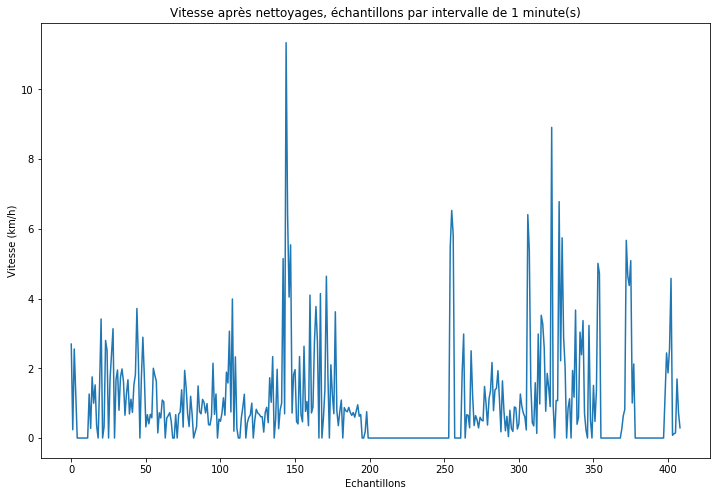

In [98]:
speedDf = cleanMethodMinutes(frame[frame["Id"] == 11], 1)
showSpeedGraph(speedDf, 1, "minute")

### Vitesses avec intervalle de 2 minutes

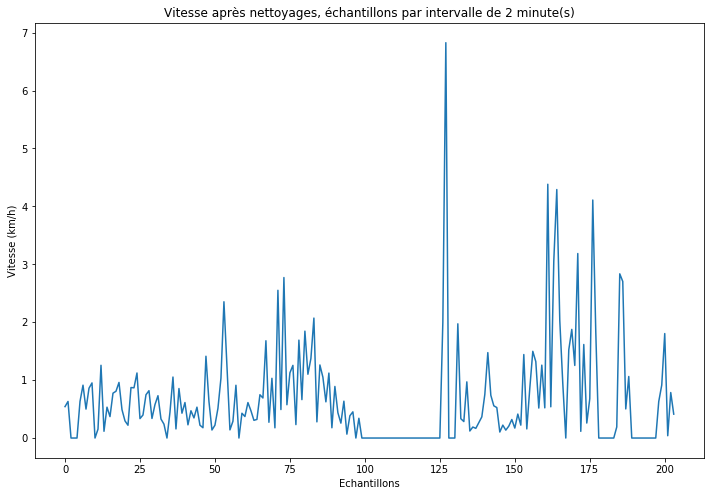

In [96]:
speedDf = cleanMethodMinutes(frame[frame["Id"] == 11], 2)
showSpeedGraph(speedDf, 2, "minute")

### Vitesses avec intervalles de 5 minutes

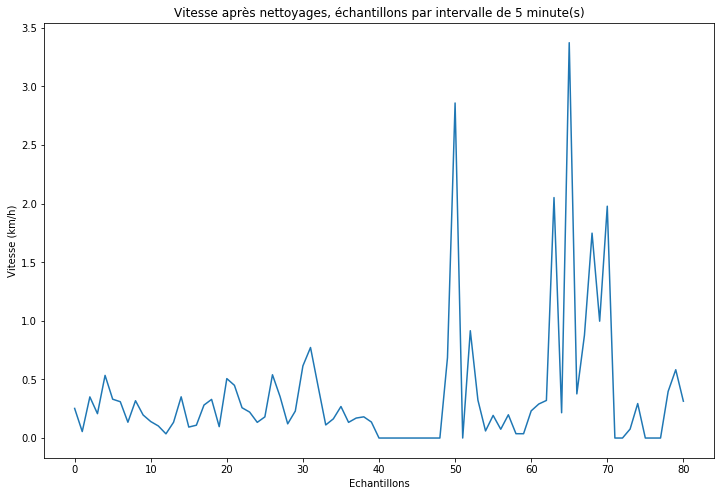

In [89]:
speedDf = cleanMethodMinutes(frame[frame["Id"] == 11], 5)
showSpeedGraph(speedDf, 5, "minute")

#### Remarques
L'algorithme à l'air de marcher correctement, à part pour les intervalles assez courts, où il existe des pics de vitesse, sûrement du fait qu'il y ait du bruit sur les données GPS.

Sinon, à part ces petits pics, les vitesses ont l'air assez correctes.

Nous pouvons aussi raisonnablement penser que les vitesses très proches de zéro sont en réalité zéro, car elles ne sûrement pas un déplacement, mais un bruit GPS.

Nous allons maintenant afficher les trajectoires pour voir si le nettoyage s'est bien passé à ce niveau.

### Affichage des trajectoires

#### Intervalles d'1 minute

In [99]:
coord11 = speedDf[["Latitude", "Longitude"]]

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as image
import matplotlib.pyplot as plt

im = image.imread('Images/map11.png')

def fct(x):
    coord11_dyn = coord11.iloc[0:x]
    lat_coord11_dyn = coord11_dyn['Longitude'].values
    long_coord11_dyn = coord11_dyn['Latitude'].values
    plt.figure(figsize=(10,10))
    #plt.xlim(0.0035, 0.0070)
    #plt.ylim(4.867,4.873)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.plot(lat_coord11_dyn, long_coord11_dyn)
    plt.xlim(4.867,4.873)
    plt.ylim(45.7735, 45.7770)
    plt.imshow(im, aspect='auto', extent=(4.866, 4.873, 45.7725, 45.7776), zorder=-1)
    plt.show()
    
interactive_plot = interactive(fct, x=(1, len(coord11)))
#plt.imshow(im, aspect='auto', extent=(4.866, 4.873, 45.7725, 45.7776), zorder=-1)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=205, description='x', max=410, min=1), Output()), _dom_classes=('widget-…

#### Intervalles de 2 minutes

In [97]:
coord11 = speedDf[["Latitude", "Longitude"]]

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as image
import matplotlib.pyplot as plt

im = image.imread('Images/map11.png')

def fct(x):
    coord11_dyn = coord11.iloc[0:x]
    lat_coord11_dyn = coord11_dyn['Longitude'].values
    long_coord11_dyn = coord11_dyn['Latitude'].values
    plt.figure(figsize=(10,10))
    #plt.xlim(0.0035, 0.0070)
    #plt.ylim(4.867,4.873)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.plot(lat_coord11_dyn, long_coord11_dyn)
    plt.xlim(4.867,4.873)
    plt.ylim(45.7735, 45.7770)
    plt.imshow(im, aspect='auto', extent=(4.866, 4.873, 45.7725, 45.7776), zorder=-1)
    plt.show()
    
interactive_plot = interactive(fct, x=(1, len(coord11)))
#plt.imshow(im, aspect='auto', extent=(4.866, 4.873, 45.7725, 45.7776), zorder=-1)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=103, description='x', max=205, min=1), Output()), _dom_classes=('widget-…

#### Intervalles de 5 minutes

In [92]:
coord11 = speedDf[["Latitude", "Longitude"]]

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as image
import matplotlib.pyplot as plt

im = image.imread('Images/map11.png')

def fct(x):
    coord11_dyn = coord11.iloc[0:x]
    lat_coord11_dyn = coord11_dyn['Longitude'].values
    long_coord11_dyn = coord11_dyn['Latitude'].values
    plt.figure(figsize=(10,10))
    #plt.xlim(0.0035, 0.0070)
    #plt.ylim(4.867,4.873)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.plot(lat_coord11_dyn, long_coord11_dyn)
    plt.xlim(4.867,4.873)
    plt.ylim(45.7735, 45.7770)
    plt.imshow(im, aspect='auto', extent=(4.866, 4.873, 45.7725, 45.7776), zorder=-1)
    plt.show()
    
interactive_plot = interactive(fct, x=(1, len(coord11)))
#plt.imshow(im, aspect='auto', extent=(4.866, 4.873, 45.7725, 45.7776), zorder=-1)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=41, description='x', max=82, min=1), Output()), _dom_classes=('widget-in…

#### Remarque
On remarque que le trajectoires nettoyées restent pour la plupart correctes.

Il y a néanmoins des différences selon les intervalles.
Par exemple, il y a un point dans les données non nettoyées qui se trouve vers le haut et la gauche qui est sûrement dû à une erreur ( la trajectoire traverse sans passer par des rues et il y a un pic de vitesse).

Ce déplacement vers le haut et la gauche est toujours présent lors de intervalles d'une minute, mais ne l'est plus avec les intervalles de 2 et 5 minutes.

Ceci est dû au fait que l'algorithme fonctionne en prenant les coordonnées GPS les plus présentes par intervalles, le point serait donc toujours là du fait que le GPS a "bugué" pendant un petit intervalle inférieur à 1 minute.

Nous affichons par la suite les images des trajectoires, si jamais cela ne marche pas sur les widgets python.

![](./Images/trajectoire_id11_1min.png)
Intervalles de 1 minute

![](./Images/trajectoire_id11_2min.png.png)
Intervalles de 2 minutes

![](./Images/trajectoire_id11_5min.png)
Intervalles de 5 minutes

## Conclusion

Nous devions déterminer en quoi une trajectoire est de bonne qualité, en fonction de différents paramètres.

Tout d'abord, il faut bien entendu que la trajectoire semble correcte, c'est à dire qu'elle suit plus ou moins les rues, et qu'il n'y ait pas de sauts dans l'espace.

Il faudrait bien entendu qu'il y ait un maximum de données pour chaque intervalle, sinon, il nous en manque, et il peut-être difficile de calculer les vitesse ou même les trajectoire ( nous avons vu qu'il y a un "vide" avec des vitesses nulles).

Nous avons aussi amélioré l'algorithme de nettoyage, mais dont l'efficacité dépend de l'intervalle de temps utilisé.
Si nous prenons un intervalle trop petit, on aura peut-être des vitesses plus précises, mais il peut subsister des erreurs au niveau des coordonnées, ce qui peut finalement fausser à des certains moments.
Par contre, quand nous prenons un intervalle plus grand on se retrouve avec moins d'erreurs au niveau des coordonnées, mais avec des vitesses moins précises.

## Prochaine séance

Nous étudierons les données WIFI et GPRS de la vraie étude, afin de pouvoir étudier les déplacement sur le campus de la DOUA.

En parallèle, nous allons aussi travailler sur D3.JS afin de visualiser ces déplacement autre part que sur les notebooks python.


